# CryptoCompare API

In [1]:
import requests
import datetime
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
from pylab import rcParams

## Current Price

In [3]:
def price(symbol, comparison_symbols=['USD'], exchange=''):
    url = 'https://min-api.cryptocompare.com/data/price?fsym={}&tsyms={}'\
            .format(symbol.upper(), ','.join(comparison_symbols).upper())
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()
    return data

In [4]:
price('BTC', exchange='Coinbase')

{'USD': 3752.11}

In [5]:
price('NEO', ['BTC', 'ETH', 'USD'])

{'BTC': 0.001943, 'ETH': 0.05727, 'USD': 7.54}

## Historical Price by Minute

In [6]:
def minute_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histominute?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

In [7]:
time_delta = 1 #in minutes (сhoose cryptocurrency and minutes intervsl)
df = minute_price_historical('BTC', 'USD', 30, time_delta)
print('Max length = %s' % len(df))
print('Max time = %s' % (df.timestamp.max() - df.timestamp.min()))

Max length = 31
Max time = 0 days 00:30:00


In [8]:
df.head()

,close,high,low,open,time,volumefrom,volumeto,timestamp
0,3824.98,3825.63,3824.73,3825.32,1545733620,81.87,311401.09,2018-12-25 12:27:00
1,3824.45,3825.09,3824.11,3824.98,1545733680,104.35,395151.48,2018-12-25 12:28:00
2,3817.48,3824.45,3816.69,3824.45,1545733740,94.21,355998.12,2018-12-25 12:29:00
3,3816.43,3817.48,3815.93,3817.48,1545733800,49.11,186027.96,2018-12-25 12:30:00
4,3814.18,3816.53,3814.14,3816.43,1545733860,38.40,145310.96,2018-12-25 12:31:00


In [9]:
df.tail()

,close,high,low,open,time,volumefrom,volumeto,timestamp
26,3811.88,3813.39,3811.24,3811.78,1545735180,24.90,96019.83,2018-12-25 12:53:00
27,3808.69,3811.88,3808.69,3811.88,1545735240,18.93,71963.04,2018-12-25 12:54:00
28,3806.07,3808.69,3805.96,3808.69,1545735300,24.40,92127.96,2018-12-25 12:55:00
29,3806.51,3807.07,3805.87,3806.07,1545735360,6.16,23224.00,2018-12-25 12:56:00
30,3805.70,3806.58,3805.70,3806.51,1545735420,3.55,13357.96,2018-12-25 12:57:00


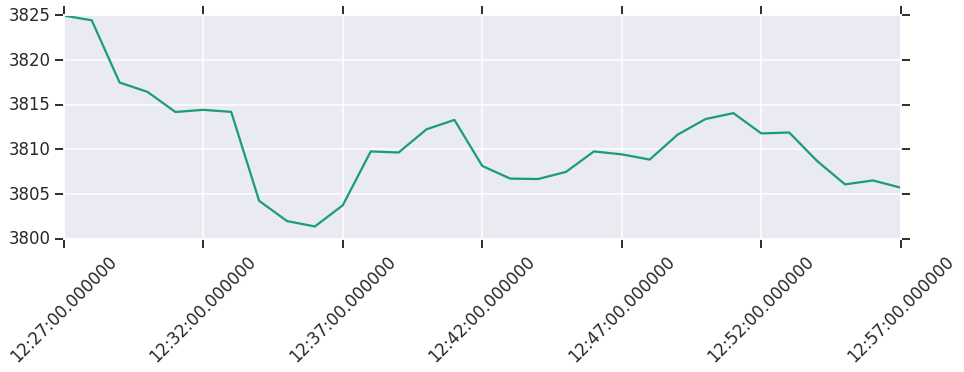

In [10]:
rcParams['figure.figsize'] = 15, 4
plt.plot(df.timestamp, df.close)
plt.xticks(rotation=45)
plt.show()

# Moving Average 

In [11]:
df = minute_price_historical('BTC', 'USD',1000, time_delta)

In [12]:
date_df = df[['timestamp']]

In [13]:
df = df[['close']]

In [14]:
df.head()

,close
0,4127.29
1,4129.24
2,4132.06
3,4127.01
4,4125.70


In [15]:
short_rolling = df.rolling(window=20).mean()
short_rolling.head()

,close
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [16]:
# Calculating the long-window simple moving average
long_rolling = df.rolling(window=100).mean()
long_rolling.tail()

,close
996,3819.3606
997,3819.4025
998,3819.4621
999,3819.5404
1000,3819.6128


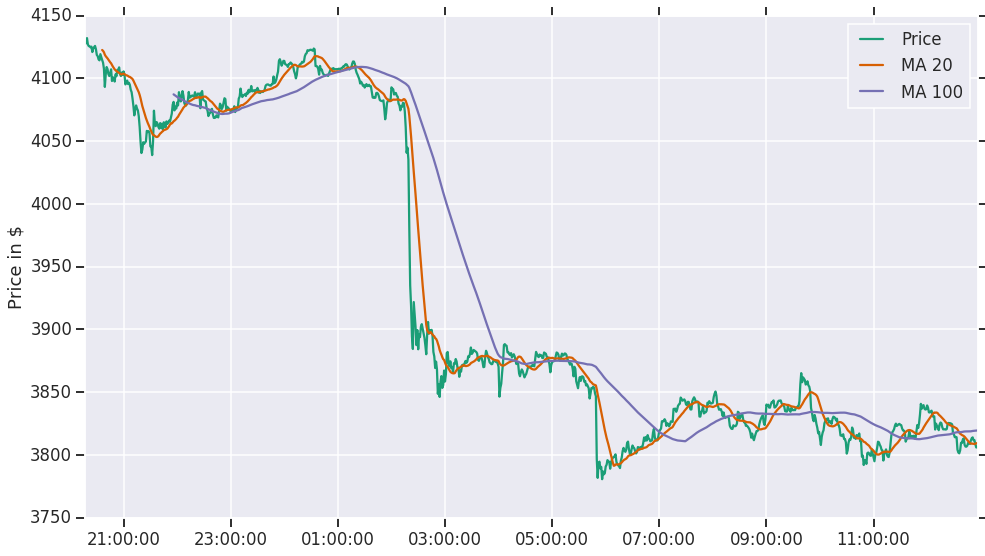

In [17]:
rcParams['figure.figsize'] = 15, 4

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(date_df.timestamp, df.close, label='Price')
ax.plot(date_df.timestamp, short_rolling, label= 'MA 20')
ax.plot(date_df.timestamp, long_rolling, label = 'MA 100')
ax.legend(loc='best')
ax.set_ylabel('Price in $')

In [18]:
ema_short = df.ewm(span=20, adjust=False).mean()

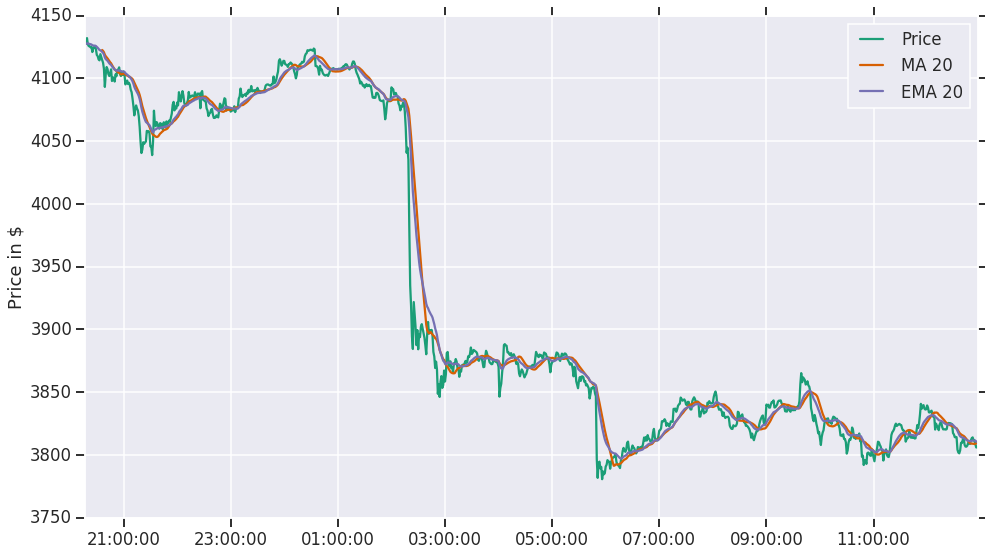

In [19]:
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(date_df.timestamp, df.close, label='Price')
ax.plot(date_df.timestamp, short_rolling, label= 'MA 20')
ax.plot(date_df.timestamp, ema_short, label = 'EMA 20')
ax.legend(loc='best')
ax.set_ylabel('Price in $')

In [20]:
# Taking the difference between the prices and the EMA timeseries
trading_positions_raw = df - ema_short
trading_positions_raw.tail()


,close
996,0.279406
997,-2.633395
998,-4.753071
999,-3.902303
1000,-4.326845


In [21]:
# Taking the sign of the difference to determine whether the price or the EMA is greater and then multiplying by 1/3
trading_positions = trading_positions_raw.apply(np.sign) * 1/3
trading_positions.tail()


,close
996,0.333333
997,-0.333333
998,-0.333333
999,-0.333333
1000,-0.333333


In [22]:
# Lagging our trading signals by one day.
trading_positions_final = trading_positions.shift(1)

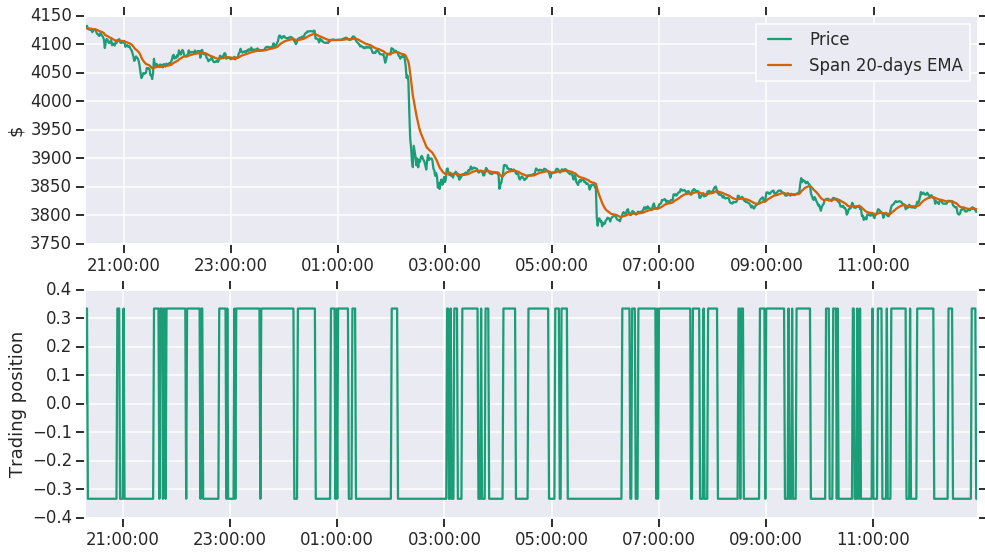

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

ax1.plot(date_df.timestamp, df.close, label='Price')
ax1.plot(date_df.timestamp, ema_short, label = 'Span 20-days EMA')

ax1.set_ylabel('$')
ax1.legend(loc='best')

ax2.plot(date_df.timestamp, trading_positions_final, label='Trading position')

ax2.set_ylabel('Trading position')

In [24]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
asset_log_returns = np.log(df).diff()
asset_log_returns.head()

,close
0,NaN
1,0.000472
2,0.000683
3,-0.001223
4,-0.000317


In [25]:
strategy_asset_log_returns = trading_positions_final * asset_log_returns
strategy_asset_log_returns.tail()

,close
996,0.000009
997,-0.000279
998,0.000229
999,-0.000039
1000,0.000077


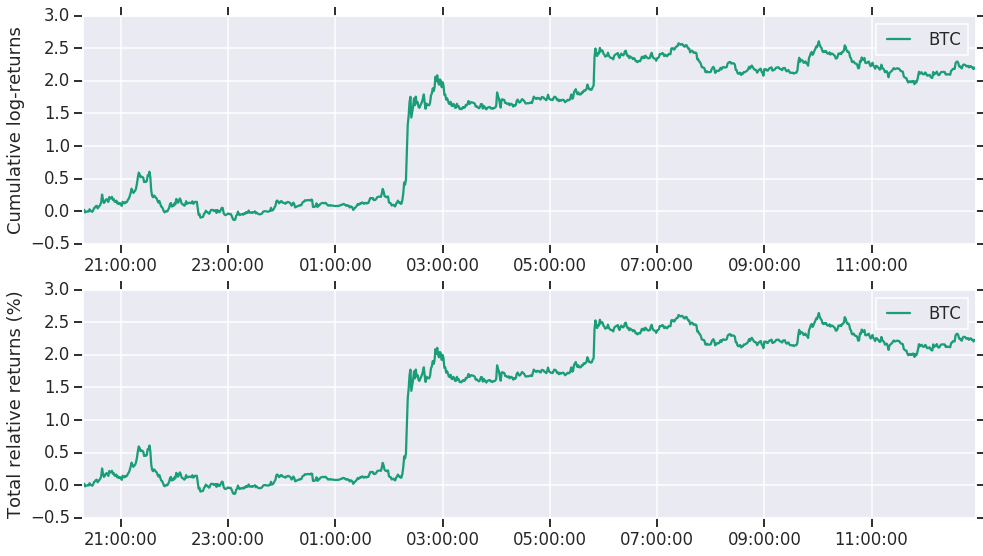

In [26]:
# Get the cumulative log-returns per asset
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns = np.exp(cum_strategy_asset_log_returns) - 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

ax1.plot(date_df, 100*cum_strategy_asset_log_returns, label="BTC")

ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')

ax2.plot(date_df, 100* cum_strategy_asset_relative_returns, label="BTC") #in percents

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')

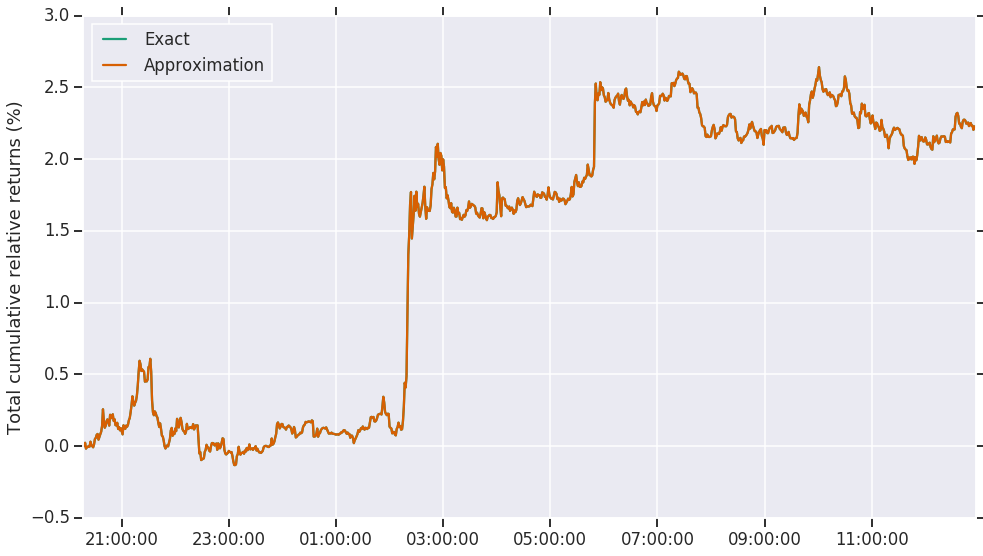

In [27]:
# Total strategy relative returns. This is the exact calculation.
cum_relative_return_exact = cum_strategy_asset_relative_returns.sum(axis=1)

# Get the cumulative log-returns per asset
cum_strategy_log_return = cum_strategy_asset_log_returns.sum(axis=1)

# Transform the cumulative log returns to relative returns. This is the approximation
cum_relative_return_approx = np.exp(cum_strategy_log_return) - 1

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(date_df, 100*cum_relative_return_exact, label='Exact')
ax.plot(date_df, 100*cum_relative_return_approx, label='Approximation')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
